<a href="https://colab.research.google.com/github/MacherelR/AutonomousRcCar/blob/main/Lane_Navigation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount google drive 4/1AY0e-g7Avb32AWPPmFcHrsjdLUd3EqoMWCg7dlwldmIeho1fPOAqcIXiRZI
from google.colab import drive
drive.mount('/content/gdrive')
model_output_dir = '/content/gdrive/My Drive/Colab Notebooks/LaneNavigation'


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


IMPORTS

In [ ]:
# python standard libraries
import os
import random
import fnmatch
import datetime
import pickle

# data processing
import numpy as np
np.set_printoptions(formatter={'float_kind':lambda x: "%.4f" % x})

import pandas as pd
pd.set_option('display.width', 300)
pd.set_option('display.float_format', '{:,.4f}'.format)
pd.set_option('display.max_colwidth', 200)

# tensorflow
import tensorflow as tf
import keras
from keras.models import Sequential  # V2 is tensorflow.keras.xxxx, V1 is keras.xxx
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.optimizers import Adam
from keras.models import load_model

print( f'tf.__version__: {tf.__version__}' )
print( f'keras.__version__: {keras.__version__}' )

# sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# imaging
import cv2
from imgaug import augmenters as img_aug
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image






tf.__version__: 2.4.1
keras.__version__: 2.4.3


Load datas


AutonomousRcCar  AutonomousRcCar_1  AutonomousRcCar_2  gdrive  sample_data
image_path: /content/AutonomousRcCar/Datas/images/video01_075_080.png
steering_Angle: 80


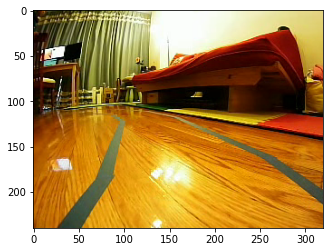

In [ ]:
!cd /content
if not os.path.isdir("AutonomousRcCar"):
  !git clone https://github.com/MacherelR/AutonomousRcCar
!ls

dataDirectory = '/content/AutonomousRcCar/Datas/images'

file_list = os.listdir(dataDirectory)
img_path = []
steeringList = []

pattern = "*.png"
for fName in file_list:
  if fnmatch.fnmatch(fName,pattern):
    img_path.append(os.path.join(dataDirectory,fName))
    angle = int(fName[-7:-4]) # last numbers
    steeringList.append(angle)

test = True
# Test
idx = 20
if test :
  plt.imshow(Image.open(img_path[idx]))
  print("image_path: %s" % img_path[idx] )
  print("steering_Angle: %d" % steeringList[idx] )
  df = pd.DataFrame()
  df['ImagePath'] = img_path
  df['Angle'] = steeringList


Check angle distribution

(array([1.0000, 1.0000, 8.0000, 4.0000, 5.0000, 11.0000, 6.0000, 7.0000,
        26.0000, 2.0000, 10.0000, 21.0000, 18.0000, 23.0000, 15.0000,
        21.0000, 12.0000, 10.0000, 2.0000, 5.0000, 2.0000, 1.0000, 3.0000,
        2.0000, 3.0000]),
 array([44.0000, 46.3600, 48.7200, 51.0800, 53.4400, 55.8000, 58.1600,
        60.5200, 62.8800, 65.2400, 67.6000, 69.9600, 72.3200, 74.6800,
        77.0400, 79.4000, 81.7600, 84.1200, 86.4800, 88.8400, 91.2000,
        93.5600, 95.9200, 98.2800, 100.6400, 103.0000]),
 <a list of 25 Patch objects>)

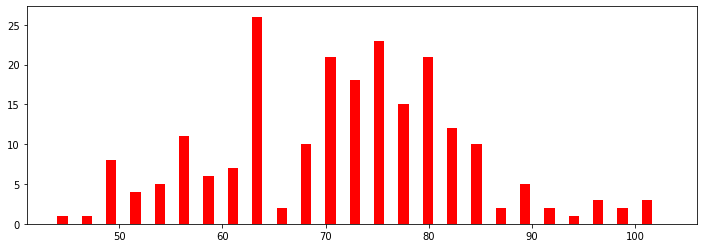

In [ ]:
nBins = 25
samplesPerBin = 400
hist , bins = np.histogram(df['Angle'],nBins)

fig,axes = plt.subplots(1,1,figsize=(12,4))
axes.hist(df['Angle'],bins= nBins,width = 1,color='red')

Splitting datas

Training data: 175
Validation data: 44


Text(0.5, 1.0, 'Validation Data')

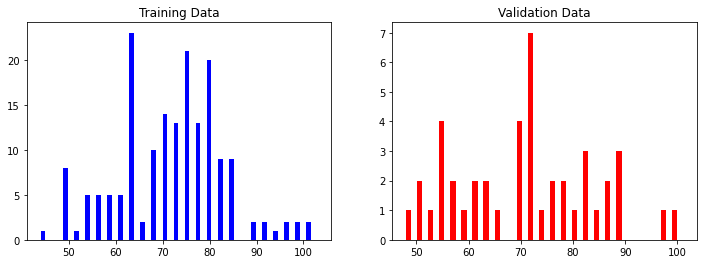

In [ ]:
X_train, X_validation, y_train, y_validation = train_test_split(img_path,steeringList, test_size= 0.2)
print("Training data: %d\nValidation data: %d" % (len(X_train), len(X_validation)))

# plot the distributions of train and valid, make sure they are consistent
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(y_train, bins=nBins, width=1, color='blue')
axes[0].set_title('Training Data')
axes[1].hist(y_validation, bins=nBins, width=1, color='red')
axes[1].set_title('Validation Data')

**Data expansion**:
To train correctly we need to expand our sets of datas
Few methods :
1.   Zoom: crop out a smaller image from the center
2.   Pan: crop out a smaller image from left or right side
3.   adjust brightness of the image
4.   flip the image horizontally, i.e do a left to right flip, and change the  steering angle coorespondingly
5.   introduce an Gaussian blur

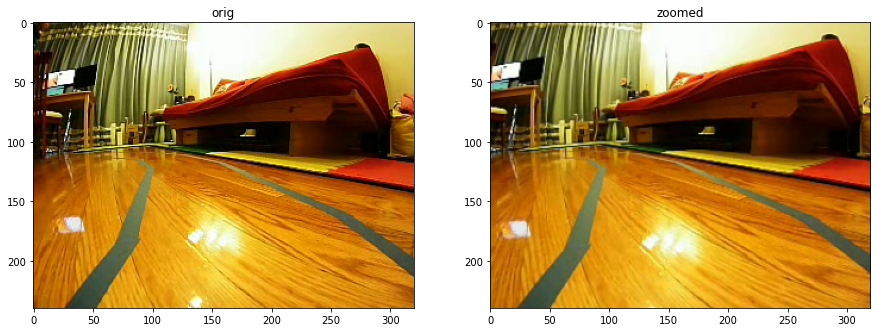

In [ ]:
def imreadModif(imgPath):
  image = cv2.imread(imgPath)
  image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
  return image

def zoom(image):
  zoom = img_aug.Affine(scale= (1,1.3)) # zoom to 130%
  img = zoom.augment_image(image)
  return img
if test:
  fig, axes = plt.subplots(1, 2, figsize=(15, 10))
  image_orig = imreadModif(img_path[idx])
  image_zoom = zoom(image_orig)
  axes[0].imshow(image_orig)
  axes[0].set_title("orig")
  axes[1].imshow(image_zoom)
  axes[1].set_title("zoomed")


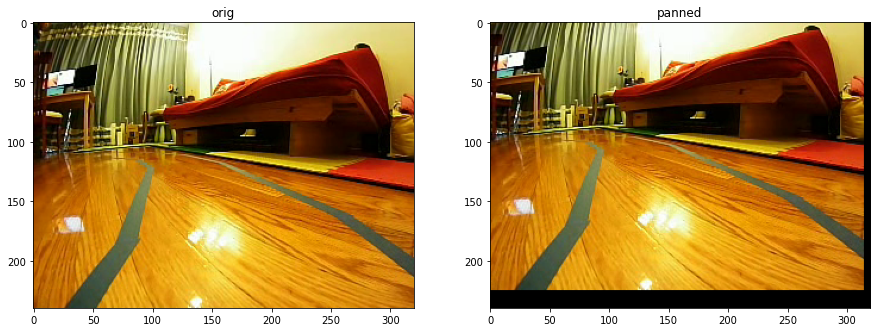

In [ ]:
def pan (image) :
  pan = img_aug.Affine(translate_percent={"x" : (-0.1,0.1), "y" : (-0.1,0.1)})
  img = pan.augment_image(image)
  return img
if test :
  fig, axes = plt.subplots(1, 2, figsize=(15, 10))
  image_orig = imreadModif(img_path[idx])
  image_pan = pan(image_orig)
  axes[0].imshow(image_orig)
  axes[0].set_title("orig")
  axes[1].imshow(image_pan)
  axes[1].set_title("panned")

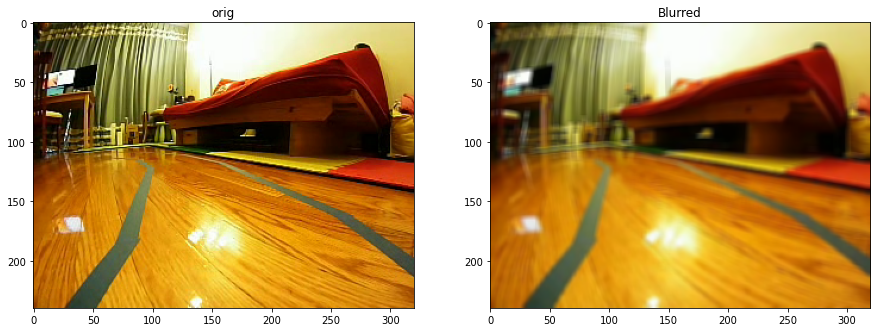

In [ ]:
def GaussianBlur (image):
  kernelSize = random.randint(1,5) # 5 is the blurry limit
  img = cv2.blur(image,(kernelSize,kernelSize))
  return img

if test :
  fig, axes = plt.subplots(1, 2, figsize=(15, 10))
  image_orig = imreadModif(img_path[idx])
  image_blurred = GaussianBlur(image_orig)
  axes[0].imshow(image_orig)
  axes[0].set_title("orig")
  axes[1].imshow(image_blurred)
  axes[1].set_title("Blurred")


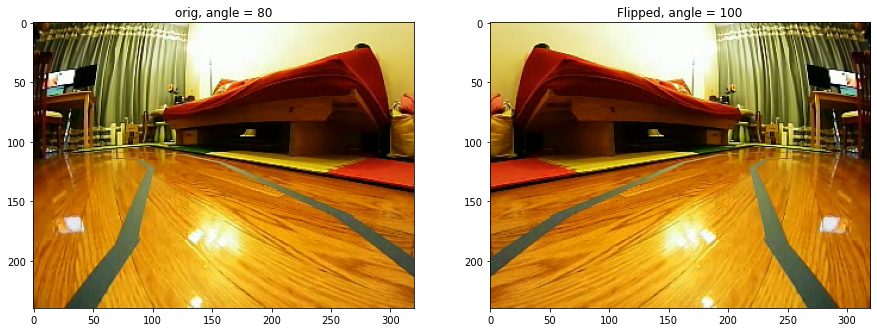

In [ ]:
def flipImage(image,steeringValue):
  isFlip = random.randint(0,1) #randomly flip the image
  if isFlip == 1:
    #flip the horizon
    image = cv2.flip(image,1)
    steeringValue = 180 - steeringValue
  return image,steeringValue

if test :
  fig, axes = plt.subplots(1, 2, figsize=(15, 10))
  image_orig = imreadModif(img_path[idx])
  image_flip, steeringAngle = flipImage(image_orig,steeringList[idx])
  axes[0].imshow(image_orig)
  axes[0].set_title("orig, angle = %s" % steeringList[idx])
  axes[1].imshow(image_flip)
  axes[1].set_title("Flipped, angle = %s" % steeringAngle)

**Randomly modify all images :**
Applying randomly those modifications on images to augment dataset size

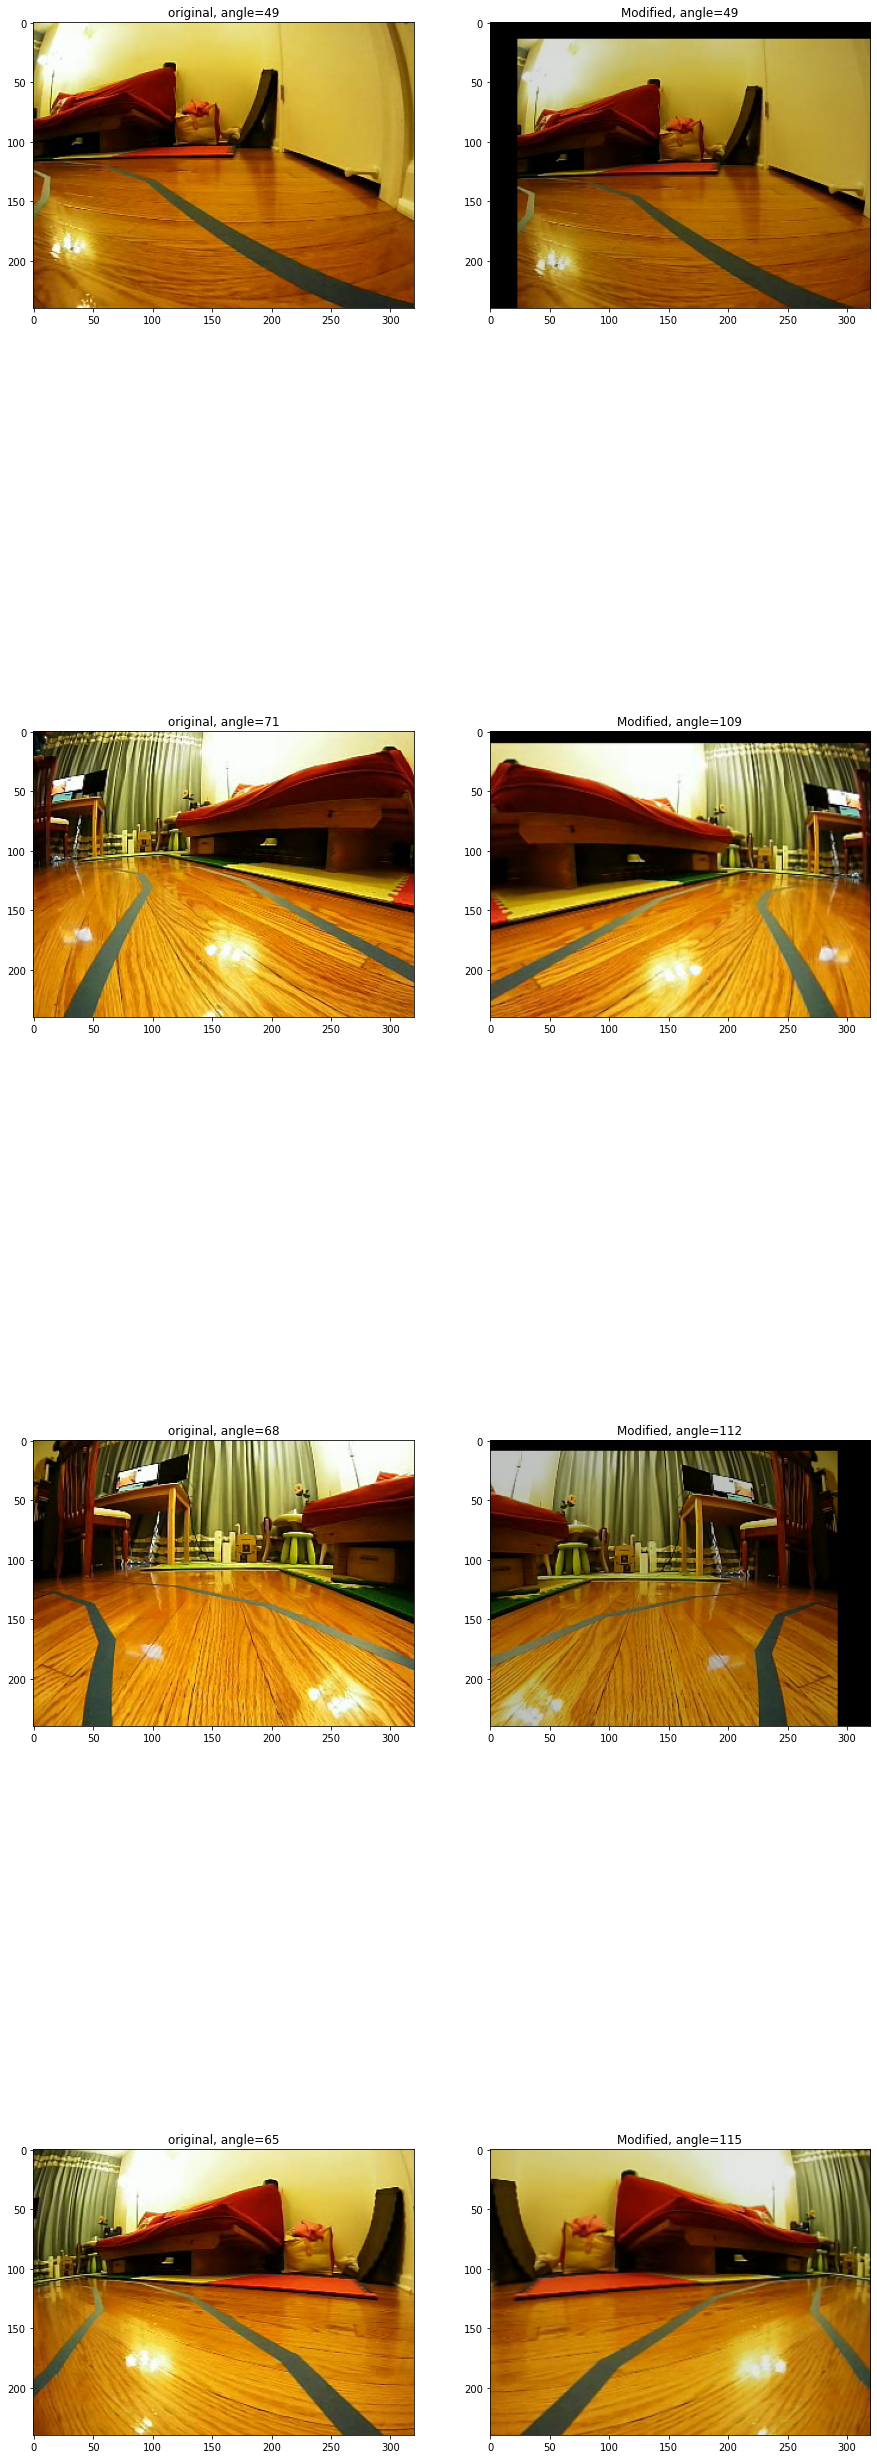

In [ ]:

def adjustBrightness(image):
    # increase or decrease brightness by 30%
    brightness = img_aug.Multiply((0.7, 1.3))
    image = brightness.augment_image(image)
    return image

def randomModify (image,steeringAngle):
  if np.random.rand() < 0.5:
    image = pan(image)
  if np.random.rand() < 0.5:
    image = zoom(image)
  if np.random.rand() < 0.5:
    image = GaussianBlur(image)
  if np.random.rand() < 0.5:
    image = adjustBrightness(image)
  image, steeringAngle = flipImage(image, steeringAngle)

  return image,steeringAngle

if test :
  # show a few randomly augmented images
  ncol = 2
  nrow = 4
  fig, axes = plt.subplots(nrow, ncol, figsize=(15, 50))

  for i in range(nrow):
      rand_index = random.randint(0, len(img_path) - 1)
      image_path = img_path[rand_index]
      steering_angle_orig = steeringList[rand_index]
      
      image_orig = imreadModif(image_path)
      image_aug, steering_angle_aug = randomModify(image_orig, steering_angle_orig)
      
      axes[i][0].imshow(image_orig)
      axes[i][0].set_title("original, angle=%s" % steering_angle_orig)
      axes[i][1].imshow(image_aug)
      axes[i][1].set_title("Modified, angle=%s" % steering_angle_aug)

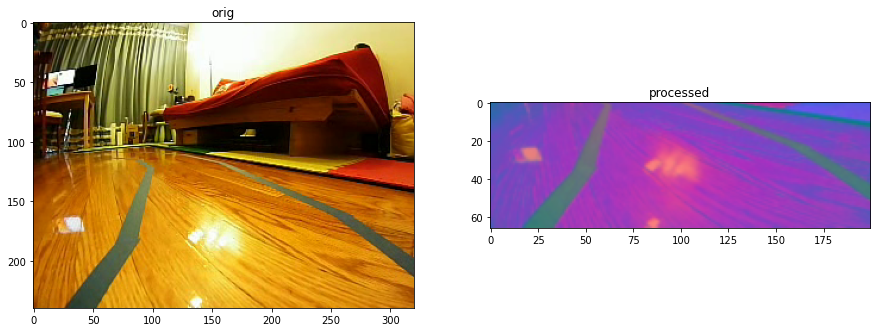

In [ ]:
def ImagePreprocess (image):
  height, _, _ = image.shape
  image = image[int(height/2):,:,:]  # remove top half of the image, as it is not relavant for lane following
  image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)  # Nvidia model said it is best to use YUV color space
  image = cv2.GaussianBlur(image, (3,3), 0)
  image = cv2.resize(image, (200,66)) # input image size (200,66) Nvidia model
  image = image / 255 # normalizing, the processed image becomes black for some reason.  do we need this?
  return image

if test :
  fig, axes = plt.subplots(1, 2, figsize=(15, 10))
  image_orig = imreadModif(img_path[idx])
  image_processed = ImagePreprocess(image_orig)
  axes[0].imshow(image_orig)
  axes[0].set_title("orig")
  axes[1].imshow(image_processed)
  axes[1].set_title("processed")

**CREATE AND TRAIN NVIDIA MODEL**

In [ ]:
def nvidia_model():
    model = Sequential(name='Nvidia_Model')
    
    # elu=Expenential Linear Unit, similar to leaky Relu
    # skipping 1st hiddel layer (nomralization layer), as we have normalized the data
    
    # Convolution Layers
    model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu')) 
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu')) 
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu')) 
    model.add(Conv2D(64, (3, 3), activation='elu')) 
    model.add(Dropout(0.2)) # not in original model. added for more robustness
    model.add(Conv2D(64, (3, 3), activation='elu')) 
    
    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dropout(0.2)) # not in original model. added for more robustness
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    
    # output layer: turn angle (from 45-135, 90 is straight, <90 turn left, >90 turn right)
    model.add(Dense(1)) 
    
    # since this is a regression problem not classification problem,
    # we use MSE (Mean Squared Error) as loss function
    optimizer = Adam(lr=1e-3) # lr is learning rate
    model.compile(loss='mse', optimizer=optimizer)
    
    return model

In [ ]:
model = nvidia_model()
print(model.summary())

Model: "Nvidia_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
dropout_6 (Dropout)          (None, 3, 20, 64)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 1152)             

In [ ]:
def dataGenerator(imagePaths, steeringAngles,batchSize,isTraining):
  while True:
    batchImages = []
    batchSteering = []
    for i in range(batchSize):
      randomIdx = random.randint(0,len(imagePaths)-1)
      imagePath = imagePaths[randomIdx]
      image = imreadModif(imagePath)
      steeringAngle = steeringAngles[randomIdx]
      if isTraining:
        # Image modification for training
        image,steeringAngle = randomModify(image,steeringAngle)

      image = ImagePreprocess(image)
      batchImages.append(image)
      batchSteering.append(steeringAngle)
    yield (np.asarray(batchImages),np.asarray(batchSteering))

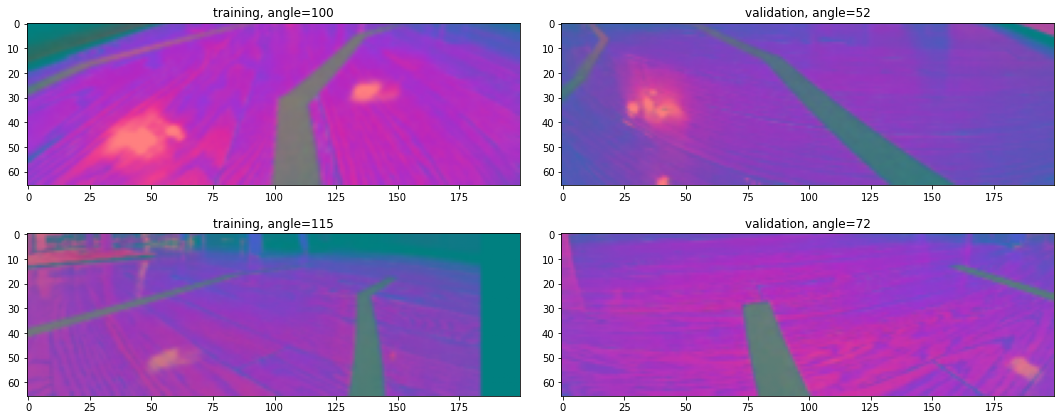

In [ ]:
ncols = 2
nrows = 2

xTrainBatch,yTrainBatch = next(dataGenerator(X_train,y_train,nrows,True))
xValidationBatch,yValidationBatch = next(dataGenerator(X_validation,y_validation,nrows,False))

fig,axes = plt.subplots(nrows,ncols,figsize = (15,6))
fig.tight_layout()

for i in range(nrows):
  axes[i][0].imshow(xTrainBatch[i])
  axes[i][0].set_title("training, angle=%s" % yTrainBatch[i])
  axes[i][1].imshow(xValidationBatch[i])
  axes[i][1].set_title("validation, angle=%s" % yValidationBatch[i])

In [ ]:
# Start TensorBoard
logDirRoot = f'{model_output_dir}/logs'

In [ ]:
#Prevent training to start if you press "Run all" (Makes an error in compiling)
DO_NOT_RUN_ALL


NameError: ignored

**TRAINING MODEL**

In [ ]:
if 0 :
  checkpointCallback = keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_output_dir,'laneNavigationCheck.h5'),verbose=1,save_best_only=True)
  history = model.fit(dataGenerator( X_train, y_train, batchSize=100, isTraining=True),
                                steps_per_epoch=300,
                                epochs=10,
                                validation_data = dataGenerator( X_validation, y_validation, batchSize=100, isTraining=False),
                                validation_steps=200,
                                verbose=1,
                                shuffle=1,
                                callbacks=[checkpointCallback])
  # always save model output as soon as model finishes training
  model.save(os.path.join(model_output_dir,'lane_navigation_final.h5'))

  date_str = datetime.datetime.now().strftime("%y%m%d_%H%M%S")
  history_path = os.path.join(model_output_dir,'history.pickle')
  with open(history_path, 'wb') as f:
      pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
#print(img_path[idx])
#img = Image.open(img_path[idx])
#print(img.shape)
#plt.imshow(img)

/content/AutonomousRcCar/Datas/images/video01_075_080.png


AttributeError: ignored

**Tests**


[94.1726]


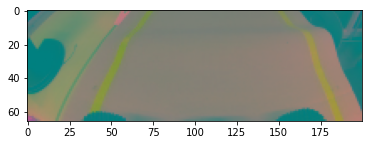

In [99]:
modelDirectory = '/content/AutonomousRcCar/Model/lane_navigation.h5'
model = load_model(modelDirectory)
img = imreadModif('/content/AutonomousRcCar/Image1.png')
preprocessed = ImagePreprocess(img)
plt.imshow(preprocessed)
X = np.asarray([preprocessed])
steering = model.predict(X)[0]

print(steering)


# Nouvelle section